In [1]:
%cd ../tfa

/home/work/AnacondaProjects/HTFATorch/tfa


In [2]:
# import dependencies
import logging
import tfa as TFA
import utils

/home/work/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


02/09/2018 23:41:41 [Epoch 1] (120863ms) Posterior free-energy 2.25359220e+07
02/09/2018 23:43:41 [Epoch 2] (119896ms) Posterior free-energy 1.71798720e+07
02/09/2018 23:45:41 [Epoch 3] (119758ms) Posterior free-energy 1.50122890e+07
02/09/2018 23:47:41 [Epoch 4] (119637ms) Posterior free-energy 1.37148520e+07
02/09/2018 23:49:40 [Epoch 5] (119683ms) Posterior free-energy 1.35031360e+07
02/09/2018 23:51:40 [Epoch 6] (119635ms) Posterior free-energy 1.40363560e+07
02/09/2018 23:53:40 [Epoch 7] (119714ms) Posterior free-energy 1.27425750e+07
02/09/2018 23:55:39 [Epoch 8] (119873ms) Posterior free-energy 1.27248270e+07
02/09/2018 23:57:39 [Epoch 9] (119755ms) Posterior free-energy 1.33444160e+07
02/09/2018 23:59:39 [Epoch 10] (119757ms) Posterior free-energy 1.21555680e+07
02/10/2018 00:01:39 [Epoch 11] (119655ms) Posterior free-energy 1.23151880e+07
02/10/2018 00:03:38 [Epoch 12] (119725ms) Posterior free-energy 1.33565900e+07
02/10/2018 00:05:38 [Epoch 13] (119767ms) Posterior free-ener

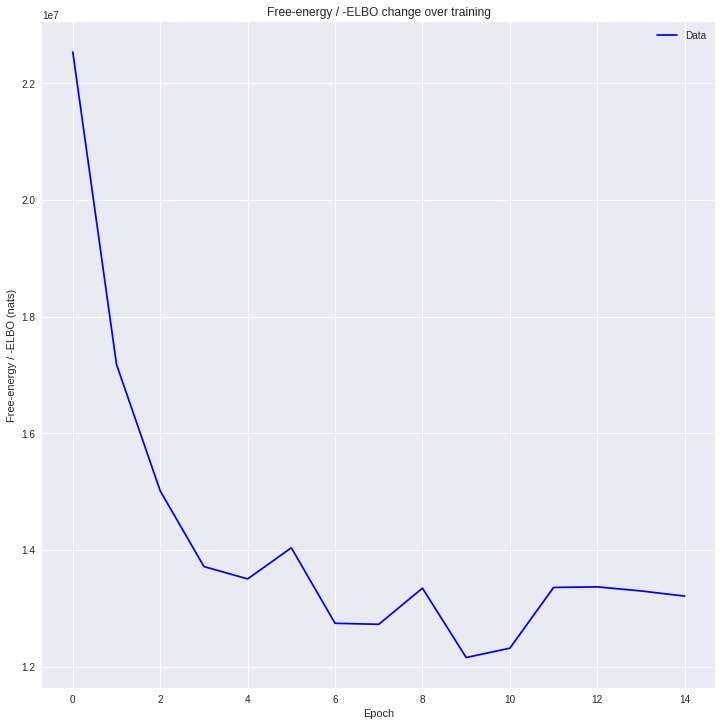

02/10/2018 00:09:38 Mean Factor Centers: [[  10.369854   -100.03989      -2.748721  ]
 [  71.52227      66.086586     34.55862   ]
 [ -49.298084     34.567333    -13.12642   ]
 [  66.64164     -83.4851        8.639586  ]
 [  47.177826     13.49518      29.301092  ]
 [  75.65852     -33.7553      -34.92609   ]
 [  68.1913       56.274883      7.142511  ]
 [  13.219673     70.48416      12.093951  ]
 [ -49.011383    -24.631886     -1.7025954 ]
 [  62.990036     24.121372     45.857822  ]
 [  56.427        11.219294    -24.25444   ]
 [  19.744482    -15.966817     51.21925   ]
 [  10.597634    -41.023724    -13.032475  ]
 [  32.43806      39.510235     55.72327   ]
 [   1.2515237    -6.3474045     3.821717  ]
 [  94.61045      -8.557077    -34.736588  ]
 [  83.34311     -38.528015     48.375763  ]
 [  78.57333      10.2590685    45.157776  ]
 [  15.381148     23.105532     16.01634   ]
 [  53.4357      -61.511635     20.782549  ]
 [   1.6440315   -43.453125     17.807856  ]
 [  17.408281 

In [3]:
tfa = TFA.TopographicalFactorAnalysis('/home/work/AnacondaProjects/HTFATorch/data/pieman_data/sub-001-task-intact1.nii', num_factors=50)
losses = tfa.train(num_steps=15, log_level=logging.INFO)

utils.plot_losses(losses)

means = tfa.mean_parameters(log_level=logging.INFO)

results = tfa.results()
logging.info(results)

In [4]:
import hypertools as hyp
import numpy as np
import seaborn as sns

import nilearn.plotting as niplot

from nilearn.input_data import NiftiMasker
import nibabel as nib
import scipy.spatial.distance as sd

from IPython.display import YouTubeVideo, HTML

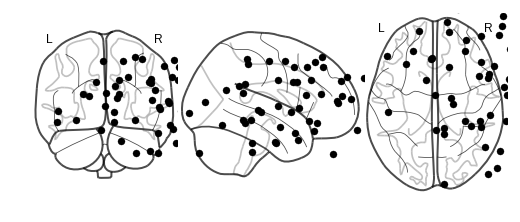

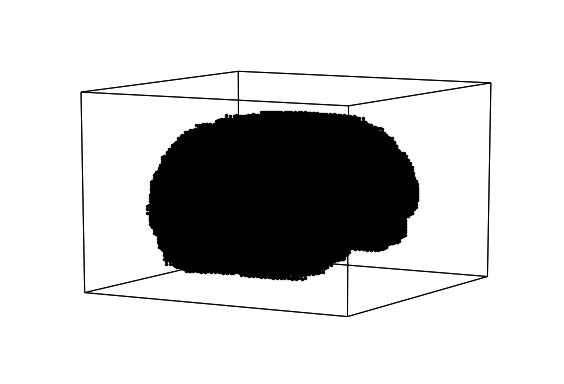

In [5]:
niplot.plot_connectome(np.eye(tfa.num_factors), means['mean_factor_center'], node_color='k')
hyp.plot(tfa.voxel_locations.numpy(), 'k.')